I've been perusing the online coding book [The Nature of Code](http://natureofcode.com/) recently. So far I really like it, especially its approach to demonstrating how one may use mathematics and code to model natural phenomena in a fun a way. I thought I would take a brief break from optics-based posts to blog about some thoughts I've had recently about one of the concepts in the book.

In the introduction I came across the concept of [Perlin noise](http://freespace.virgin.net/hugo.elias/models/m_perlin.htm), a concept which is named after its inventor Ken Perlin who, at the time of its creation, was working on computer-generated graphics for the movie Tron. Perlin developed his namesake algorithm for generating artificial yet natural-looking textures, something that previously was difficult to do with purely deterministic mathematical tools. He later won an Academy Award for this work because it greatly enabled computer artists to model realistic textures and motion.

In [1]:
%pylab inline
from numpy.fft import fft, fftshift, ifft, ifftshift
plt.style.use('dark_background')

Populating the interactive namespace from numpy and matplotlib


# Uncorrelated noise
One reason that Perlin noise models many natural phenomena so well is that its randomness is correlated. To see what I mean by this, I'll first plot a single realization of a purely random signal composed of random integers between 0 and 1. The samples from this signal are **not** correlated.

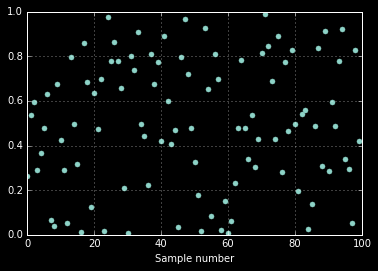

In [2]:
numSamples = 100

x       = np.arange(numSamples)
samples = np.random.rand(numSamples)

plt.plot(x, samples, '.', markersize = 10)
plt.xlabel('Sample number')
plt.grid(True)
plt.show()

In the plot above, you can see that the value of each sample from our random signal is uncorrelated with all the other samples. This situation is similar to flipping a coin; the result of a coin flip (heads or tails) doesn't depend on the previous or next flip of the coin.

If we want to use this random signal to model something natural, such as a landscape, we would be disappointed:

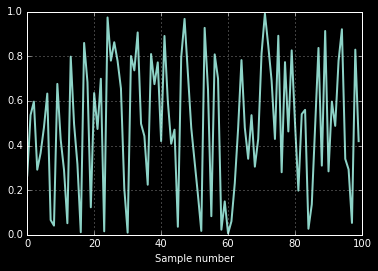

In [3]:
plt.plot(x, samples, linewidth = 2)
plt.xlabel('Sample number')
plt.grid(True)
plt.show()

Our purely random landscape is much too jagged to even come close to approximating a real-looking landscape.

# Correlated noise

Perlin noise is a way of generating a random signal whose samples are correlated over short distances but uncorrelated over longer distances. I haven't yet found any quick and easy implementations for generating Perlin noise in Python, but you can find many examples of on the web, such as [1D Perlin noise images from Google Image search](https://www.google.ch/search?q=perlin+noise&tbm=isch&tbo=u&source=univ&sa=X&ved=0ahUKEwi1ytjsx5jLAhXE_3IKHWrfAGkQsAQIPg&biw=1366&bih=644#tbm=isch&q=perlin+noise+1d). (By "quick and easy", I mean something I can install from Anaconda and use with only a couple minutes of reading the docs.)

A long time ago I wrote a computer simulation that modeled the motion of a small dipole in a three-dimensional, random electromagnetic field. This involved moving the dipole in a ballistic manner over short times, where the particle's [mean-squared-displacement (MSD)](https://en.wikipedia.org/wiki/Mean_squared_displacement) evolved quadratically with time, and smoothly rounding off to a random, diffusive motion characterized by a linear time dependence of the MSD at long times. I have also done some partial coherence modeling of illumination systems, which also involves generating correlated noise.

The point is that I have often needed to generate correlated noise on a computer, but had never come across the concept of Perlin noise until now. Traditionally, I have used fast Fourier transform (FFT)-based approaches, so I am now wondering whether the generation of correlated noise with the FFT and Perlin noise is more-or-less equivalent.

## Generating correlated noise using FFT's
Below is a relatively simple code snippet that generates a correlated noise signal. It was inspired by [work publised by Xiao and Voelz](https://www.osapublishing.org/oe/abstract.cfm?uri=oe-14-16-6986) in 2006 for modeling partially coherent laser beam propagation through turbulence.

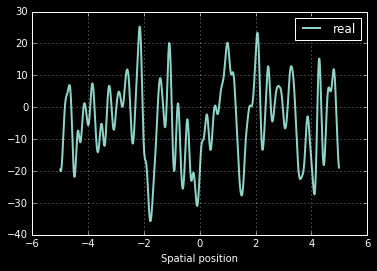

In [4]:
M  = 2**10  # Size of the 1D grid
L  = 10      # Physical size of the grid
dx = L / M  # Sampling period
fs = 1 / dx # Sampling frequency
df = 1 / L  # Spacing between frequency components
x  = np.linspace(-L/2, L/2,   num = M, endpoint = False)
f  = np.linspace(-fs/2, fs/2, num = M, endpoint = False)


sigma_f = 0.1
sigma_r = 1

# Define a Gaussian function and an uncorrelated random function in frequency space
F = fftshift(np.exp(-np.pi**2 * sigma_f**2 * f**2))
R = np.random.randn(f.size) + 1j * np.random.randn(f.size)

# Convert the product of the two functions back to real space
noise = 2 * np.pi * ifftshift(ifft(F * R)) * sigma_r / dx / np.sqrt(df)

# Plot the real and imaginary parts of the noise signal
plt.plot(x, np.real(noise), linewidth = 2, label = 'real')
#plt.plot(x, np.imag(noise), linewidth = 2, label = 'imaginary')
plt.xlabel('Spatial position')
plt.grid(True)
plt.legend(loc = 'best')
plt.show()

This algorithm actually produces two independent and random signals that are correlated over distances comparable to `sigma_f`; one signal comes from the real part and the other from the imaginary part. I only plotted the real part because we only need one. At distances larger than `sigma_f` the signal is uncorrelated. The strength of the fluctuations is determined by `sigma_r`, which is the square root of the variance of the underlying, uncorrelated random signal.

To better understand how this algorithm it works, I think it's illustrative to plot the product of `F` and `R` from the code above before they are inverse Fourier transformed.

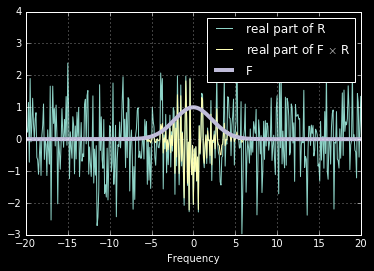

In [5]:
plt.plot(f, np.real(ifftshift(R)),   label = 'real part of R')
plt.plot(f, np.real(ifftshift(F*R)), label = r'real part of F $\times$ R')
plt.plot(f, ifftshift(F),            linewidth = 4, label = 'F')
plt.xlim((-20, 20))
plt.xlabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

As you can see, the frequency space multiplication is essentially modulating a zero-mean, Gaussian random signal with a Gaussian envelope centered at the origin. We then compute the inverse Fourier transform of this product, scale it by a few factors to ensure that energy is conserved, and take the real or imaginary parts to get two different, random, yet smooth signals. If you're familiar with Fourier transforms, you will probably recognize that the frequency space multiplication of F and R is equivalent to the real space convolution of their individual Fourier transform pairs. Thus, we've essentially smoothed a random signal with a Gaussian blurring kernel.

Though we could easily have done this with a convolution and avoided the need to think in frequency space, the visualization above is illustrative for this reason: **we have essentially modified the amplitudes of the various spectral components of the uncorrelated random signal, producing correlated noise in the process**.

What happens if we shape the random signal's spectrum differently, for example by using a top hat function instead of a Gaussian? Below is a plot the real part of the random signal generated from the top hat filtering compared to the previous one.

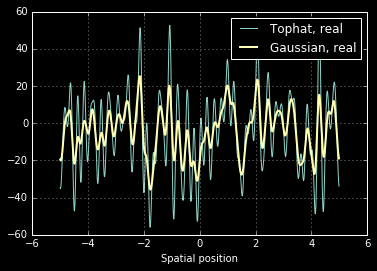

In [6]:
# Define a Gaussian function and an uncorrelated random function in frequency space
F_tophat = np.ones(f.size)

# Set values outside of the width of the tophat to zero.
F_tophat[np.logical_or(f < -0.5 / sigma_f, f > 0.5 / sigma_f)] = 0
F_tophat = fftshift(F_tophat)

# Convert the product of the two functions back to real space
noise_tophat = 2 * np.pi * ifftshift(ifft(F_tophat * R)) * sigma_r / dx / np.sqrt(df)

# Plot the real and imaginary parts of the noise signal
plt.plot(x, np.real(noise_tophat), linewidth = 1, label = 'Tophat, real')
plt.plot(x, np.real(noise),        linewidth = 2, label = 'Gaussian, real')
plt.xlabel('Spatial position')
plt.grid(True)
plt.legend()
plt.show()

We still have smooth, large-scale fluctuations that are about the same size as the inverse width of the top hat, but now there are additional high-frequency fluctuations which lead to a more "jagged" appearance in the blue, top hat curve above.

For completeness, here's how the real part of the spectrum is reshaped by multiplying by a top hat.

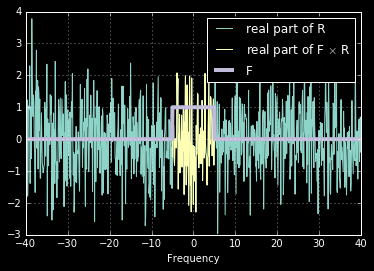

In [7]:
plt.plot(f, np.real(ifftshift(R)),          label = 'real part of R')
plt.plot(f, np.real(ifftshift(F_tophat*R)), label = r'real part of F $\times$ R')
plt.plot(f, ifftshift(F_tophat),            linewidth = 4, label = 'F')
plt.xlim((-40, 40))
plt.xlabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

## Reasoning about the differences
So far we've learned that we could create correlated noise by filtering a zero-mean, Gaussian random signal in frequency space. We also learned that the nature of the resulting signals changes when the shape of the frequency space filter is modified. In the case of the top hat filter, the resulting random signal became a bit more jagged. This makes sense because the amplitudes of the mid-range spectral components were larger for the top hat filtered signal; there was no smooth Gaussian rolloff but instead a hard cutoff at +/- `0.5 / sigma_f`. Even though the Gaussian-filtered signal had a larger bandwidth, the high frequency amplitudes were diminished exponentially, so they essentially didn't matter.

# The connection with Perlin noise
Conceptually, Perlin noise is generated by adding together curves with different amplitudes and frequencies [as explained here](http://freespace.virgin.net/hugo.elias/models/m_perlin.htm). This is similar to what we did in the examples above: we took sine waves with random phases and different frequencies, modulated their amplitudes, and then added them together to get a realization of a smooth random signal.

So what are the differences between the two approaches then? Here's what I can think of for now.
1. FFT's use sine waves for their basis functions; Perlin noise uses curves that have been interpolated from random numbers.
2. The frequencies of the sine waves in the FFT approach have a fixed spacing; the frequencies in Perlin noise are on an octave scale (each successive frequency is twice as much as the previous one).

This last point probably means that we can't apply the FFT approach to generate Perlin noise without some modifications because the FFT expects frequency samples at fixed, linear intervals. Once I find a Python implementation of Perlin noise, I'll try to better understand how it's generated and see whether it's fundamentally different than the FFT approach above.

# One last example: 1/f noise
I realized the day after writing the draft of this post that the above discussion is useful for illustrating some of the "colored" noises. In this case, we use the ideas presented above to generate a realization of [1/f noise](https://en.wikipedia.org/wiki/Pink_noise), also known as *pink noise* or *fractal noise*.

Can you guess how the amplitude of the spectrum of 1/f noise varies?

Surprise! It actually varies as \\( \frac{1}{f^{1/2}} \\). This is because the **power** spectrum of pink noise varies as 1/f; the **amplitude** of the spectral components is the square root of the average power delivered by each component. The [proper Wikipedia sections on energy and power spectral densities](https://en.wikipedia.org/wiki/Spectral_density#Energy_spectral_density) explain this. The difficulty in actually implementing this filter, though, is what happens as we approach the DC value \\( f = 0 \\) in frequency space. At this value the filter becomes infinite.

Instead, we can easily approximate a realization of pink noise with a filter that is one near the origin and quickly rolls off into a \\( f^{-1/2} \\) behavior. A function that does this is

$$H \left( f \right) = \frac{1}{\sqrt{1 + af}}$$

The value \\( a \\) determines how quickly the function moves from a weak dependence on frequency to a \\( f^{-1/2} \\) dependence. For us, we should set it to a value that is relatively large compared to the frequency spacing in Fourier space. This type of filter is just a special case of the [Chebyshev filter](https://en.wikipedia.org/wiki/Chebyshev_filter) that is well-known in signal processing circles.

In [8]:
# Define the pink noise frequency-space filter for our random uncorrelated signals
def pinkNoiseFilter(freq):
    freq = np.abs(freq)
    return 1 / np.sqrt(1 + 10 * freq)
    
pinkNoiseFilter = np.vectorize(pinkNoiseFilter)

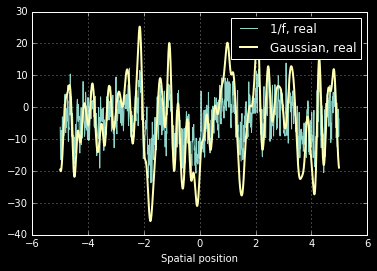

In [9]:
F_pinkNoise = fftshift(pinkNoiseFilter(f))

# Convert the product of the two functions back to real space
noise_pink = 2 * np.pi * ifftshift(ifft(F_pinkNoise * R)) * sigma_r / dx / np.sqrt(df)

# Plot the real and imaginary parts of the noise signal
plt.plot(x, np.real(noise_pink), linewidth = 1, label = '1/f, real')
plt.plot(x, np.real(noise),      linewidth = 2, label = 'Gaussian, real')
plt.xlabel('Spatial position')
plt.grid(True)
plt.legend()
plt.show()

Now we have the same general trends in the 1/f noise signal as in the realization of the Gaussian signal, but with a lot of high frequency noise added.

We can see that the high frequency noise is coming from poor suppression of high frequencies in the filtered spectrum. Remember that this is the spectrum of just one realization of the noise, this time without the real part of the random signal for clarity.

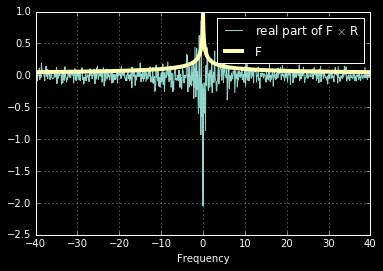

In [10]:
plt.plot(f, np.real(ifftshift(F_pinkNoise*R)), label = r'real part of F $\times$ R')
plt.plot(f, ifftshift(F_pinkNoise),            linewidth = 4, label = 'F')
plt.xlim((-40, 40))
plt.xlabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

Pretty cool! Though I still haven't made a good connection with Perlin noise, I now have a better understanding of how to generate many different kinds of realizations of noise signals on a computer. The general recipe is to
1. generate a completely uncorrelated, zero-mean random signal in frequency space,
2. multiply this signal by a filter that shapes the amplitudes of the signal,
3. and perform an inverse FFT to bring the signal back into real space. We get two random signals for the price of one; one from the real part and one from the imaginary part.